<a href="https://colab.research.google.com/github/SaketMunda/transfer-learning-with-tensorflow/blob/master/scaling_up_transfer_learning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scaling Up Food Vision 101 using Transfer Learning with TensorFlow

We're going to move forward with Food Vision 101 dataset and scale up with all the classes(previously we did with 10 classes) in Food101 dataset and build a Food Vision Mini.

In [ ]:
# Are we using a gpu ?
!nvidia-smi

Thu Jan  5 04:49:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Tesla T4 GPU we are using.

## Load 10% of Food101 Dataset

In the original Food101 dataset, there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 images.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

In [1]:
# Download the helper function
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

# Import functions from helper_functions.py
from helper_functions import unzip_data, walk_through_dir, create_tensorboard_callback, plot_loss_curves

--2023-01-06 04:57:24--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-01-06 04:57:24 (47.1 MB/s) - ‘helper_functions.py’ saved [2904/2904]



In [2]:
# Download Zipfile of Food101 Dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

# Unzip the file
unzip_data('101_food_classes_10_percent.zip')

# walking through the directory
# walk_through_dir('101_food_classes_10_percent')

--2023-01-06 04:57:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.9MB/s    in 68s     

2023-01-06 04:59:04 (22.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



## Preprocess the Loaded Data (10%)

We can preprocess using `image_dataset_from_directory` function to turn our images and labels into a `tf.data.Dataset`, a tensorflow datatype which allows us to pass it directory to our model.

In [3]:
# Setup data inputs
import tensorflow as tf
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                batch_size=BATCH_SIZE,
                                                                                image_size=IMG_SHAPE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SHAPE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)# don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


It looks like our training dataset contain, 75 images per class (101 classes) and test dataset contain, 250 images per class from 101 classes.

## Train a transfer learning Model on 10% of 101 food classes

We're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

Our modelling setup will be:
- A ModelCheckpoint callback to save our progress during training, this means we could experiment further training later without having to train from scratch every time.
- Data Augmentation built right into the model
- A headless(no top layers) EfficientNetB0 architecture from `tf.keras.applications` as our base model
- A `Dense` layer with 101 hidden neurons (same as the number of food classes) and softmax activation as the output layer
- Categorical Crossentropy as the loss function since we're dealing with more than two classes
- The Adam optimizer with the default settings
- Fitting for full 5 passes on the training data while evaluating 15% of the test data.


In [ ]:
# Start with creating a ModelCheckpoint
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                              save_best_only=True, # save the best model weights on file (delete the rest)
                                                              save_weights_only=True, # save weights only
                                                              monitor='val_accuracy') # save the model weights which score the best validation accuracy

In [ ]:
# data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    #preprocessing.Rescaling(1/255.) keep for models like ResNet50
])

In [ ]:
# Create the base_model
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # so that we can add our own output layers
base_model.trainable=False

# Setup the model architecture with trainable top layers
inputs = layers.Input(shape=IMG_SHAPE+(3,), name='input_layer') # shape of input layer
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base_model in inference mode so we can use it to extract features without updating weights
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) # pool the outputs of the basemodel and learn only the important features
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


Model is created, let's inspect it.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

Our functional model has 5 layers but each of those layers have varying amounts of layers within them.

Time to compile and fit.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# fit the model
initial_epoch = 5

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=initial_epoch,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[modelcheckpoint_callback])

Epoch 1/5
237/237 [==============================] - 100s 354ms/step - loss: 3.3738 - accuracy: 0.2746 - val_loss: 2.4644 - val_accuracy: 0.4611
Epoch 2/5
237/237 [==============================] - 65s 272ms/step - loss: 2.2155 - accuracy: 0.5001 - val_loss: 2.0518 - val_accuracy: 0.5082
Epoch 3/5
237/237 [==============================] - 61s 257ms/step - loss: 1.8443 - accuracy: 0.5620 - val_loss: 1.8887 - val_accuracy: 0.5257
Epoch 4/5
237/237 [==============================] - 58s 242ms/step - loss: 1.6157 - accuracy: 0.6038 - val_loss: 1.8117 - val_accuracy: 0.5334
Epoch 5/5
237/237 [==============================] - 52s 219ms/step - loss: 1.4833 - accuracy: 0.6331 - val_loss: 1.7349 - val_accuracy: 0.5495


Evaluate the model on full test dataset

In [ ]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 58s 73ms/step - loss: 1.5829 - accuracy: 0.5818


[1.5828856229782104, 0.5817821621894836]

Well it looks like **we just beat our baseline (the results from the original Food101 paper) with 10% of the data** In under 5-minutes... that's the power of deep learning and more precisely transfer learning: leveraging what one model has learned on another dataset for our own dataset.

How do the loss curves looks like ?

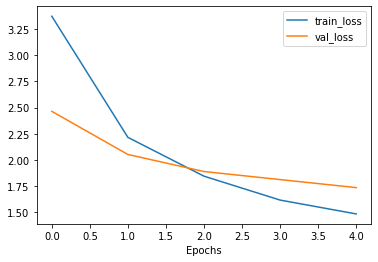

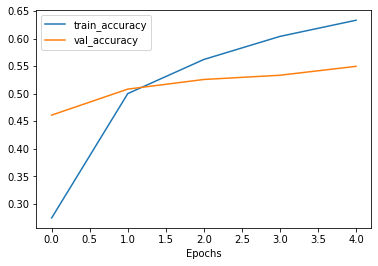

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-Tuning

Our feature extraction transfer model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements ?

The good news is, thanks to `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.



In [ ]:
# unfreeze all the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

Since we have make the last 5 layers which is closer to our output layer, and the layers which are closer to output layer will try to learn the larger and high-level patterns or weights from our own dataset of images.

Now we have to re-compile the model.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Fit or train for another 5 epochs
fine_tune_epochs = initial_epoch + 5

# fit the model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data,
                                             validation_steps=int(0.15 * len(test_data)),
                                             initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 60s 222ms/step - loss: 1.2341 - accuracy: 0.6829 - val_loss: 1.7346 - val_accuracy: 0.5434
Epoch 6/10
237/237 [==============================] - 49s 205ms/step - loss: 1.1296 - accuracy: 0.7003 - val_loss: 1.7804 - val_accuracy: 0.5358
Epoch 7/10
237/237 [==============================] - 48s 202ms/step - loss: 1.0430 - accuracy: 0.7189 - val_loss: 1.7103 - val_accuracy: 0.5559
Epoch 8/10
237/237 [==============================] - 53s 220ms/step - loss: 0.9827 - accuracy: 0.7373 - val_loss: 1.7750 - val_accuracy: 0.5376
Epoch 9/10
237/237 [==============================] - 46s 190ms/step - loss: 0.9129 - accuracy: 0.7560 - val_loss: 1.7626 - val_accuracy: 0.5413
Epoch 10/10
237/237 [==============================] - 44s 183ms/step - loss: 0.8737 - accuracy: 0.7661 - val_loss: 1.7698 - val_accuracy: 0.5424


In [ ]:
# Evaluate the fine-tuned model with all the test dataset
results_fine_tune_model = model.evaluate(test_data)
results_fine_tune_model

790/790 [==============================] - 58s 73ms/step - loss: 1.4979 - accuracy: 0.6034


[1.4979487657546997, 0.6034455299377441]

We might get a better picture by comparing the histories of both the trained models,

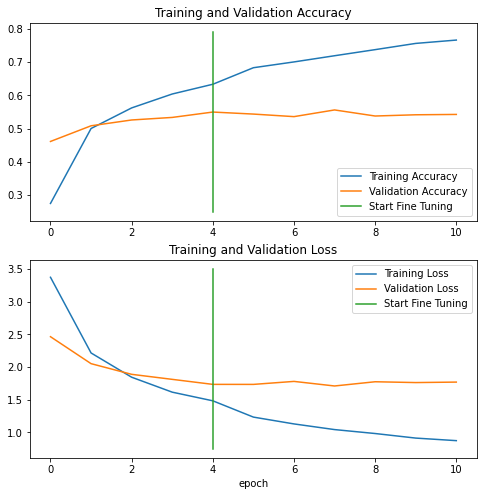

In [ ]:
import matplotlib.pyplot as plt

original_history = history_all_classes_10_percent
new_history = history_all_classes_10_percent_fine_tune


# get the original history measurement
acc = original_history.history['accuracy']
loss = original_history.history['loss']

val_acc = original_history.history['val_accuracy']
val_loss = original_history.history['val_loss']

# combine original history with new history
total_acc = acc + new_history.history['accuracy']
total_loss = loss + new_history.history['loss']

total_val_acc = val_acc + new_history.history['val_accuracy']
total_val_loss = val_loss + new_history.history['val_loss']


#epochs = range(0, original_history.epoch + new_history.epoch)
# Make plot for accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.title('Training and Validation Accuracy')
plt.plot(total_acc, label='Training Accuracy')
plt.plot(total_val_acc, label="Validation Accuracy")
plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')

# Make plot for loss
plt.subplot(2,1,2)
plt.title('Training and Validation Loss')
plt.plot(total_loss, label='Training Loss')
plt.plot(total_val_loss, label='Validation Loss')
plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.xlabel('epoch');

It seems that after fine-tuning our validation loss and accuracy doesn't get benefited and model is starting to overfit.

If feature extraction results already were well, the improvements you see from fine-tuning may not be great as if your dataset was significantly different from the data your base model was pre-trained on.

## Save our Trained Model

To prevent having to retrain our model from scratch, let's save it to file using the `save()` method

In [ ]:
model.save('drive/MyDrive/Data Science/101_food_class_10_percent_saved_big_dog_model')

## Evaluating the performance of the big dog model across all different classes

We've got our model trained and saved and also according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's deep dive a little into our model's performance and get some visualizations going.

> **Note**: Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled by good looking training numbers.

In [4]:
import tensorflow as tf

# Download the whole data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

# Load the trained model
model = tf.keras.models.load_model('drive/MyDrive/Data Science/101_food_class_10_percent_saved_big_dog_model')

--2023-01-06 04:59:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  13.0MB/s    in 3.4s    

2023-01-06 04:59:25 (13.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



To make sure our loaded model is indeed a trained model, let's evaluate its performance on the test dataset,

In [5]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)

loaded_loss, loaded_accuracy

790/790 [==============================] - 70s 77ms/step - loss: 1.4979 - accuracy: 0.6034


(1.4979486465454102, 0.6034455299377441)

Alright ! It seems that our trained model is loaded as it was saved.

### Make predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us some indication of how the model will perform in the real world data to what it has been trained for.

In [6]:
# Make prediction on test dataset
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 63s 79ms/step


We just passed all of the test images to the model to predict.

So if we had just passed 25250 images to predict, then the model should return the same number of prediction of each image in form of tensors of probabilities.

In [ ]:
len(pred_probs)

25250

And if each image could be one of 101 classes, then in `pred_probs` each index must have 101 probabilities of each class.

In [ ]:
pred_probs[0].shape, pred_probs.shape

((101,), (25250, 101))

What we've got if often referred to as a **predictions probability tensor**(or an array)

Let's see what the first 2 looks like,

In [ ]:
pred_probs[:2]

array([[3.32878113e-01, 2.42559487e-04, 1.00782856e-01, 1.10265802e-07,
        3.35489995e-06, 2.51639176e-06, 8.94802433e-05, 5.30661555e-06,
        5.56094348e-02, 3.51617462e-04, 3.75587638e-06, 8.00699854e-06,
        5.59849490e-04, 6.53181530e-07, 2.81937071e-03, 1.24338525e-03,
        3.17674458e-05, 5.37165441e-04, 6.61070505e-03, 2.91172710e-05,
        1.19574624e-03, 7.37397249e-06, 2.59085529e-04, 2.09261532e-04,
        7.11215485e-04, 2.11614091e-03, 7.72598956e-04, 8.75981641e-06,
        8.56867507e-02, 5.34575246e-03, 6.94469554e-06, 1.69773877e-03,
        5.68129763e-04, 4.97878455e-06, 1.14152944e-02, 2.96349072e-06,
        6.36621699e-05, 1.14167586e-03, 2.73771062e-02, 7.34940404e-05,
        1.15268840e-03, 6.19139615e-03, 2.75978498e-04, 7.74565633e-05,
        1.19418546e-04, 2.52792415e-05, 7.44113699e-04, 5.53218357e-04,
        3.09097891e-06, 9.81824696e-02, 2.56598316e-04, 1.79987284e-04,
        4.82282080e-02, 2.54738797e-02, 5.94394623e-05, 1.711148

Alright it seems like we've got a bunch of tensors of really small number, how about we zoom into one of them ?

In [7]:
# we get prediction probability per class
print(f"Number of prediction probabilities of sample 5:\n {len(pred_probs[5])}")
print(f"What prediction probability sample 5 looks like:\n {pred_probs[5]}")
print(f"The class with the highest predicted probability by the model for sample 5: {pred_probs[5].argmax()}")

Number of prediction probabilities of sample 5:
 101
What prediction probability sample 5 looks like:
 [1.43612968e-03 5.66793024e-04 2.42222109e-06 2.21843042e-08
 6.63524697e-05 2.91359925e-07 2.06487528e-07 3.70382550e-05
 1.45565830e-02 7.99878407e-03 9.23311381e-05 2.60745281e-07
 8.93053027e-07 5.33940636e-07 4.67929254e-07 1.35429276e-04
 1.29060379e-06 6.95182507e-08 5.81442844e-03 1.40934992e-06
 1.69611420e-03 2.81838641e-08 7.47001081e-07 3.15858870e-07
 1.23700474e-07 2.66149709e-06 1.28277443e-05 2.96370004e-08
 4.30185219e-06 2.72786423e-07 3.56787837e-06 6.49144204e-06
 7.66505673e-06 7.35937320e-08 4.82058822e-05 4.38495647e-07
 4.98355657e-05 2.10382113e-05 2.23280769e-03 1.58288458e-06
 5.25041437e-03 4.94722917e-06 8.28593984e-05 1.42094372e-02
 4.96673711e-05 1.03320754e-05 4.43919106e-08 2.91163567e-03
 2.48193714e-07 1.77201990e-04 1.35997063e-04 8.69400174e-06
 2.77872095e-05 3.65669490e-04 5.39166067e-05 7.44335466e-06
 1.14568538e-04 1.51068634e-05 3.00143199e-

For each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer, it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probability value, the less the model thinks that the target image is that specific class.

> **Note**: Due to the nature of the softmax activation function, the sum of each prediction probabilities for a single sample will be 1 (or closer to 1)

For example,

In [ ]:
# This is what said in the above note
pred_probs[0].sum()

1.0

We can also find the index of the maximum value in each prediction probability tensor using `argmax()` method

In [8]:
pred_classes = pred_probs.argmax(axis=1)

# How do they look ?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  9,  0])

Beautiful ! We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset label we can unravel our `test_data` object (which is in the form of `tf.data.Dataset`) using the `unbatch()` method.

Doing this will give us the access to the images and lables in the test dataset. Since the labels are in one-hot encoded format, we'll take use the `argmax()` method to return the index of the label.

> **Note**: This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test data to make predictions, it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [9]:
# check the length of test data
len(test_data), len(test_data) * 32 # 32 is a batch size

(790, 25280)

In [10]:
# extracting the labels from the test_data
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

# view some y_labels
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [11]:
# How many labels are there ?
len(y_labels)

25250

It's the same number of labels as the images

### Evaluating our models predictions

A very simple evaluation is to use Scikit-learn's `accuracy_score()` function which compares the truth labels to the predicted labels and returns an accuracy socre.

In [14]:
# let's evaluate using scikit-learn libary
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

0.6034455445544554

And this should be almost same as `loaded_accuracy`

In [15]:
loaded_accuracy

0.6034455299377441

How about we get a little bit more visual with a confusion matrix ?

To do so, we'll use first tensorflow's confusion matrix using `tf.math.confusion_matrix`

In [16]:
tf.math.confusion_matrix(labels=y_labels,
                         predictions=pred_classes,
                         num_classes=len(test_data.class_names))

<tf.Tensor: shape=(101, 101), dtype=int32, numpy=
array([[ 44,   1,  18, ...,   8,   3,   5],
       [  0, 171,   0, ...,   0,   0,   0],
       [ 14,   2, 141, ...,   2,   1,   1],
       ...,
       [  2,   0,   1, ..., 151,   0,   0],
       [  1,   1,   0, ...,   0, 113,   0],
       [  2,   0,   1, ...,   3,   1, 162]], dtype=int32)>

But this can't say much about which class is been predicted correct or incorrect, we have make a visualization, so let's plot it.

In [20]:
# import libaries
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10,10), text_size=15, norm=False, savefig=False):
  """
  Makes a labelled confusion matrix comparing predictions and ground truth labels
  
  If classes is passed, confusion matrix will be labelled, if not, integer class values will be used.

  Args:
    y_true: These are the truth labels (must be same shape as y_pred)
    y_pred: Array of predicted labels (must be same shape as y_true)
    classes: Array of class labels (e.g string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10))
    text_size: Size of output figure text (default=15)
    norm: normalize values or not (default=False)
    savefig: save confusion matrix to file (default=False)
  
  Return:
    A labelled confusion matrix plot comparing y_true and y_pred  
  """

  # Create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # Colors will represent how 'correct' a class if, darker==better
  fig.colorbar(cax)

  # Are there a list of classes ?
  if classes:
    labels=classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title='Confusion Matrix',
         xlabel='Predicted label',
         ylabel='True label',
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() / cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, f'{cm[i, j]}', horizontalalignment='center', color='white' if cm[i, j] > threshold else 'black', size=text_size)

  
  # save the figure to the currect working directory
  if savefig:
    fig.savefig('confusion_matrix.png');

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

<ipython-input-20-5efaa77eb420>:60: RuntimeWarning: divide by zero encountered in long_scalars
  threshold = (cm.max() / cm.min()) / 2.
